# Mini-Batch GD and How Adverserial Examples affects its Performance

### Overview of this Notebook: <br>
#### 1. Import of Python libraries and the dataset<br>
#### 2. Tuning of the Hyperparameters of the Mini-Batch Optimiser<br>
#### 3. Training a Naive Model<br>
#### 4. Evaluate the Attack against the Naive Model<br>
#### 5. Training a Robust Model <br>
#### 6. Evaluate the Attack against the Robust Model <br>
#### 7. Comparision of the two performances <br>

## Begin by importing the relevant libraries

In [9]:
from adversary import attack, protect
from net import Net
import numpy as np
from torch.optim import Optimizer
import torch
from training import training, testing, accuracy, tune_optimizer
from minibatch import MiniBatchOptimizer
import matplotlib.pyplot as plt
from data_utils import get_mnist, build_data_loaders
import json
from pathlib import Path
import random
import pandas as pd


## Get Data and Setup

In [2]:
use_cuda = True
device = torch.device('cuda' if use_cuda and torch.cuda.is_available() else 'cpu')
train_dataset, test_dataset = get_mnist(normalize=True)

In [3]:
epsilons = np.arange(0, 0.5, 0.05)
criterion = torch.nn.CrossEntropyLoss()
epochs = 10
batch_size = 16

## Hyperparameter Tuning

### To test the tuning, just set hyperparamter_tune to True. Otherwise, there is a JSON file with previous results

In [4]:
hyperparamter_tune = True

This is the tuning setup. It initialises the Optimiser, a new Neural net and then generates a the True/False options for the flag for a Decreasing Learning rate.

In [5]:
net_tune = Net().to(device)
mini_opt_tune = MiniBatchOptimizer(net_tune.parameters()) # Just using defaults
dec_lr_set =  [0]*1 + [1]*1
random.shuffle(dec_lr_set)
fp = 'mini_tuning.json'
if not hyperparamter_tune:
    results = []

If tuning is desired, then the following will use a custom function that takes only the training dataset, and uses it as the basic for new training/testing sets to prevent overfitting on the test data. The algorithm tries out every combination of elements in its search grid.

In [6]:
if hyperparamter_tune:
    results = tune_optimizer(
    net_tune,
    train_dataset.data,
    train_dataset.targets,
    criterion,
    accuracy,
    device,
    MiniBatchOptimizer,
    epochs=10,
    search_grid={
        'lr': np.linspace(0.00001, 0.01, 1),
        'decreasing_lr': dec_lr_set,
    }, 
    batch_size=16
)

{'lr': 1e-05, 'decreasing_lr': 0}
Launching training on cuda
epoch 0	avg epoch loss = 2.296	avg epoch acc = 0.181
epoch 1	avg epoch loss = 2.288	avg epoch acc = 0.2155
epoch 2	avg epoch loss = 2.281	avg epoch acc = 0.254
epoch 3	avg epoch loss = 2.274	avg epoch acc = 0.2854
epoch 4	avg epoch loss = 2.267	avg epoch acc = 0.309
epoch 5	avg epoch loss = 2.26	avg epoch acc = 0.3286
epoch 6	avg epoch loss = 2.252	avg epoch acc = 0.3446
epoch 7	avg epoch loss = 2.245	avg epoch acc = 0.3596
epoch 8	avg epoch loss = 2.237	avg epoch acc = 0.3741
epoch 9	avg epoch loss = 2.229	avg epoch acc = 0.3881
training took 55.55 s
Avg test loss = 2.22	Avg test acc = 0.402
{'lr': 1e-05, 'decreasing_lr': 1}
Launching training on cuda
epoch 0	avg epoch loss = 2.299	avg epoch acc = 0.1648
epoch 1	avg epoch loss = 2.299	avg epoch acc = 0.1648
epoch 2	avg epoch loss = 2.299	avg epoch acc = 0.1648
epoch 3	avg epoch loss = 2.299	avg epoch acc = 0.1648
epoch 4	avg epoch loss = 2.299	avg epoch acc = 0.1648
epoch 5	

We then append any new results into the json file for the specific Optimiser so that we do not need to retread previous configurations.

In [10]:
if Path(fp).exists():
    with open(fp, 'r') as f:
        old_results = json.load(f)

    results = old_results + results

with open(fp, 'w') as f:
    json.dump(results, f, indent=2)

# Select Best Hyperparamters
with open(fp, 'r') as f:
        old_results = json.load(f)

### Here we read out the best configuration, as determined by the Test Accuracy

In [11]:
df_analysis = pd.DataFrame(results)
best_acc = 0.0
for index, row in df_analysis.iterrows():    
        trial_acc = row["metric_test"]
        if trial_acc > best_acc:
            best_acc = trial_acc
            learning_rate = round(row["lr"], 6)
            decreasing_lr = row["decreasing_lr"]

print("Best Accuracy was {}% with Learning Rate {} and Decreasing LR: {}".format(100*best_acc, learning_rate, decreasing_lr))


Best Accuracy was 99.175% with Learning Rate 0.050005 and Decreasing LR: 0


## Train the Naive Model

### Create Data Loaders with the set Batch Size and the Model
#### The layer setup is in the net.py file

In [12]:
net_naive = Net().to(device)
train_loader, test_loader = build_data_loaders(train_dataset, test_dataset, batch_size)

### Train and Test

In [13]:
mini_opt_naive = MiniBatchOptimizer(net_naive.parameters(), lr=learning_rate, decreasing_lr=decreasing_lr)
loss_train, acc_train = training(net_naive, train_loader, mini_opt_naive, criterion, accuracy, epochs=epochs, device=device)
loss_test, acc_test = testing(net_naive, test_loader, criterion, accuracy, device=device)

Launching training on cuda
batch 100	loss = 0.6558	acc = 0.8125
batch 200	loss = 0.12	acc = 1.0
batch 300	loss = 0.4539	acc = 0.9375
batch 400	loss = 0.03814	acc = 1.0
batch 500	loss = 0.3917	acc = 0.875
batch 600	loss = 0.2347	acc = 0.9375
batch 700	loss = 0.1437	acc = 0.9375
batch 800	loss = 0.1658	acc = 0.9375
batch 900	loss = 0.09529	acc = 0.9375
batch 1000	loss = 0.08687	acc = 1.0
batch 1100	loss = 0.2221	acc = 0.9375
batch 1200	loss = 0.057	acc = 1.0
batch 1300	loss = 0.04105	acc = 1.0
batch 1400	loss = 0.002612	acc = 1.0
batch 1500	loss = 0.009377	acc = 1.0
batch 1600	loss = 0.1242	acc = 0.9375
batch 1700	loss = 0.2054	acc = 0.875
batch 1800	loss = 0.122	acc = 0.9375
batch 1900	loss = 0.001416	acc = 1.0
batch 2000	loss = 0.2128	acc = 0.9375
batch 2100	loss = 0.008937	acc = 1.0
batch 2200	loss = 0.01003	acc = 1.0
batch 2300	loss = 0.0003592	acc = 1.0
batch 2400	loss = 0.1446	acc = 0.9375
batch 2500	loss = 0.1202	acc = 0.9375
batch 2600	loss = 0.008033	acc = 1.0
batch 2700	loss = 

## Attack Naive Model

In [14]:
accuracy_naive= []
losses_naive= []

for eps in epsilons:
    loss_attack, acc_attack  = attack(net_naive, criterion, test_loader, epsilon=eps, device=device)
    accuracy_naive.append(acc_attack)
    losses_naive.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.974
Epsilon: 0.05	Test Accuracy = 0.970
Epsilon: 0.10	Test Accuracy = 0.965
Epsilon: 0.15	Test Accuracy = 0.959
Epsilon: 0.20	Test Accuracy = 0.946
Epsilon: 0.25	Test Accuracy = 0.931
Epsilon: 0.30	Test Accuracy = 0.907
Epsilon: 0.35	Test Accuracy = 0.876
Epsilon: 0.40	Test Accuracy = 0.831
Epsilon: 0.45	Test Accuracy = 0.764


## Train the Robust Model

In [15]:
robust_net = Net().to(device)
protect_epochs = epochs
protect_lr = learning_rate
protect_bz = batch_size
protect_dec_lr = decreasing_lr
prot_train_loader, prot_test_loader = build_data_loaders(train_dataset, test_dataset, protect_bz)
mini_opt_proc = MiniBatchOptimizer(robust_net.parameters(), lr=protect_lr, decreasing_lr=protect_dec_lr)

### Call the protect function to make the model robust

In [16]:
robust_net = protect(robust_net, mini_opt_proc, criterion, prot_train_loader, prot_test_loader, device=device, epochs=protect_epochs)

Epoch 0.00 | Test accuracy: 0.97830
Epoch 1.00 | Test accuracy: 0.98570
Epoch 2.00 | Test accuracy: 0.98560
Epoch 3.00 | Test accuracy: 0.98620
Epoch 4.00 | Test accuracy: 0.98510
Epoch 5.00 | Test accuracy: 0.98390
Epoch 6.00 | Test accuracy: 0.98520
Epoch 7.00 | Test accuracy: 0.98490
Epoch 8.00 | Test accuracy: 0.98620
Epoch 9.00 | Test accuracy: 0.98570
training took 123.5 s


## Attack the Robust Model

In [17]:
accuracy_robust = []
losses_robust = []

for eps in epsilons:
    loss_attack, acc_attack = attack(robust_net, criterion, prot_train_loader, eps, device=device)
    accuracy_robust.append(acc_attack)
    losses_robust.append(loss_attack)

Epsilon: 0.00	Test Accuracy = 0.998
Epsilon: 0.05	Test Accuracy = 0.997
Epsilon: 0.10	Test Accuracy = 0.996
Epsilon: 0.15	Test Accuracy = 0.995
Epsilon: 0.20	Test Accuracy = 0.992
Epsilon: 0.25	Test Accuracy = 0.988
Epsilon: 0.30	Test Accuracy = 0.980
Epsilon: 0.35	Test Accuracy = 0.967
Epsilon: 0.40	Test Accuracy = 0.950
Epsilon: 0.45	Test Accuracy = 0.924


## Comparative Analysis of the Two Models

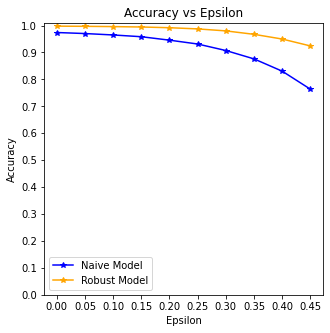

In [18]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracy_naive, "*-", c='blue', label='Naive Model')
plt.plot(epsilons, accuracy_robust, "*-", c='orange', label='Robust Model')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.5, step=0.05))

plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend();